# Evoked Excitatory Postsynaptic Currents (EPSCs)

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Synaptic_currents" folder

In [2]:
data_folder = "data/7-Synaptic_currents"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/7-Synaptic_currents


['data/7-Synaptic_currents/2025_06_13_0008.abf',
 'data/7-Synaptic_currents/2025_06_13_0020.abf',
 'data/7-Synaptic_currents/2025_06_13_0021.abf',
 'data/7-Synaptic_currents/2025_06_13_0022_100hz.abf',
 'data/7-Synaptic_currents/2025_06_13_0019.abf',
 'data/7-Synaptic_currents/2025_06_13_0018.abf',
 'data/7-Synaptic_currents/2025_06_13_0023_100hz.abf',
 'data/7-Synaptic_currents/2025_06_13_0016.abf',
 'data/7-Synaptic_currents/2025_06_13_0017.abf',
 'data/7-Synaptic_currents/2025_06_13_0015.abf',
 'data/7-Synaptic_currents/2025_06_13_0012.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [3]:
# data_file = 'data/7-Evoked_PSCs/2025_06_13_0008.abf'
# data_file = 'data/7-Evoked_PSCs/2025_06_13_0012.abf'
data_file = 'data/7-Synaptic_currents/2025_06_13_0015.abf'

Now we can load the file and plot the raw data:

Trace('2025_06_13_0015.abf')
Number of sweeps: 10
Points per sweep: 20,000
Duration per sweep: 2.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


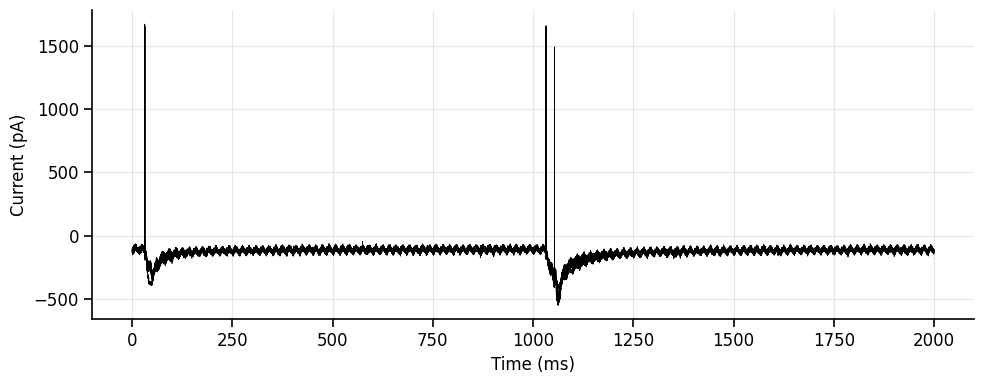

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib inline
traces.plot(plot_ttl=False, plot_voltage=False, sweep='all', time_units='ms')
# ax1, ax2 = traces.plot(plot_voltage=True, sweep='all')
plt.show()

### Optional: remove bad sweeps

In [6]:
sweeps_to_remove = []

if len(sweeps_to_remove) > 0:
    traces.remove_sweeps(sweeps_to_remove)
    ax = traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
    plt.show()

## 2. Signal processing

### Optional: apply additional highpass/lowpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [7]:
apply_filtering = True

You can run this next cell as many times as you want to fine-tune the filtering parameters:

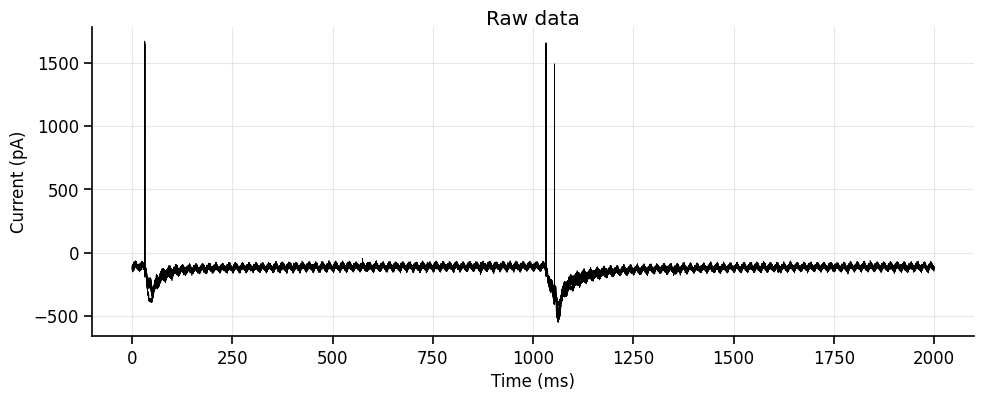

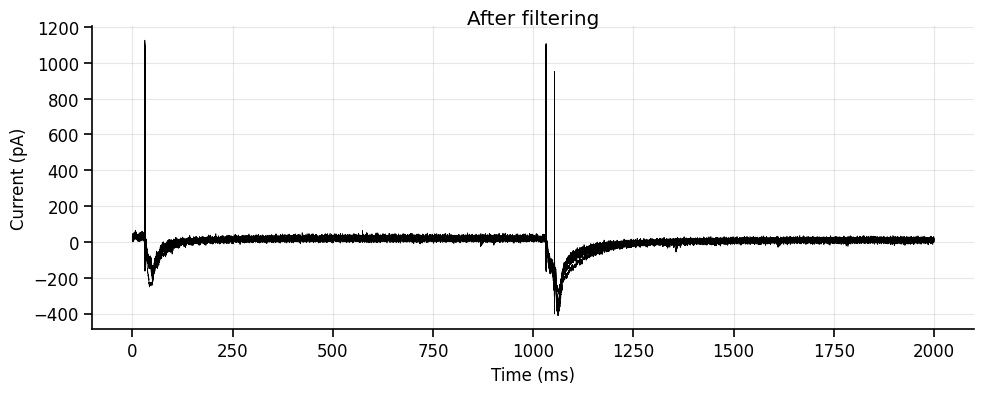

In [8]:
if apply_filtering:
    filtered_traces = traces
    # # Step 1: Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 3000) # Choose a value in units of Hz
    
    # Step 3: Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

    # Step 4: Highpass filter (removes low-frequency oscillations)
    # ------------------------------------------------------------
    # # Be extra careful with this next one, it tends to distort the data. Use only in case of emergency.
    # filtered_traces = filtered_traces.highpass_filter(cutoff_freq=0.001)
    # ------------------------------------------------------------

    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('Raw data', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('After filtering', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [9]:
if apply_filtering:
    traces=filtered_traces

### Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [10]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

BASELINE SUBTRACTED:
Baseline currents: [43.6366 30.1395 27.6811 ... 23.9119 24.8829 23.3936]


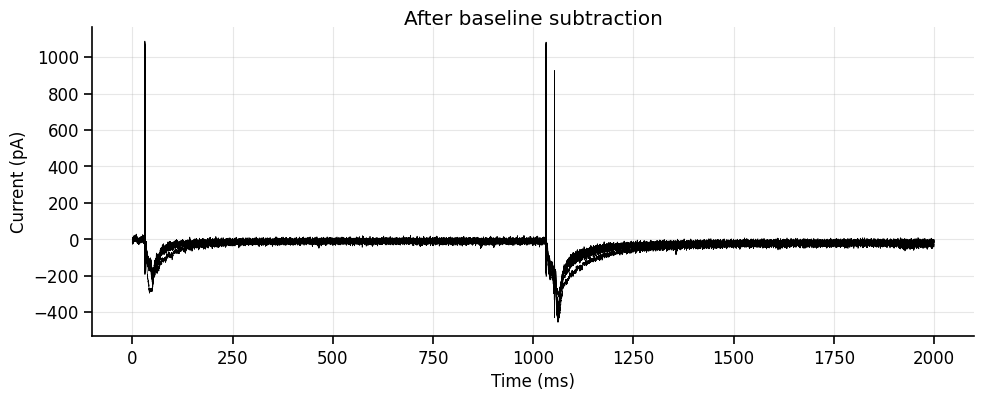

In [ ]:
if subtract_baseline:
    traces.subtract_baseline(start_time = 0, 
                             end_time = 10, 
                             time_units = time_units,
                             channel = 'all')  # Options: 'current', 'voltage', 'all'
    ax1 = traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


## 3. Measure EPSCs/IPSCs to get paired pulse ratio

(If you want to save images, click on the save icon on the left when you hover over the image)

### 3.1. Get the single-stim response


Here we will determine the event times based on where the stim artifact (capacitive transient) is

In [ ]:
# Find positive current peaks above threshold
stim_times = traces.get_event_times(threshold=200, 
                                    polarity='positive', 
                                    time_units=time_units, 
                                    channel='current', sweep=0)
print(f"Stim times: {stim_times} ms")

Stim times: [  31.3 1032.3 1053.3] ms


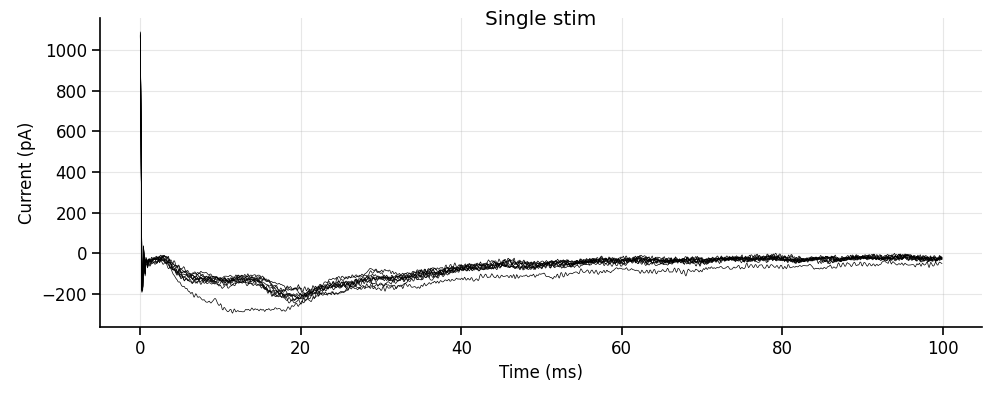

In [ ]:
window_size = 100 #ms
single_stim_traces = traces.crop(timepoint=stim_times[0], window=window_size, time_units=time_units)

%matplotlib widget
ax = single_stim_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
ax.set_title('Single stim',y=0.95)
plt.show()

#### Measure single-stim amplitudes

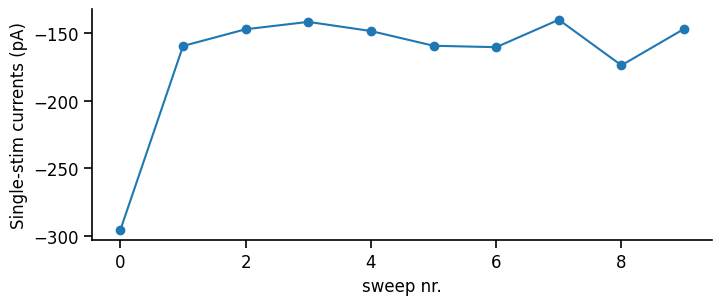

In [ ]:
single_stim_currents, _ = single_stim_traces.get_measurements(start_time=2, 
                                                            end_time=15, 
                                                            measurement_type='min', 
                                                            time_units=time_units)
%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
x = range(len(single_stim_currents))
ax.plot(x, single_stim_currents, '-o')
ax.set_ylabel('Single-stim currents (pA)')
ax.set_xlabel("sweep nr.")
plt.show()

### 3.2. Get the response to the first paired-pulse stim

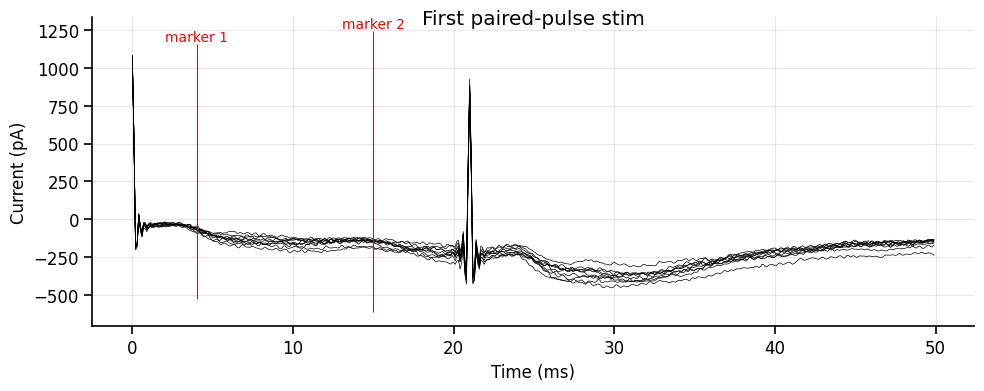

In [ ]:
marker_1 = 4
marker_2 = 15


first_pulse_traces = traces.crop(timepoint=stim_times[1], window=window_size/2, time_units=time_units)
ax = first_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all', marker_1=marker_1, marker_2=marker_2)
ax.set_title('First paired-pulse stim',y=0.95)
plt.show()

#### Measure first paired-pulse amplitudes

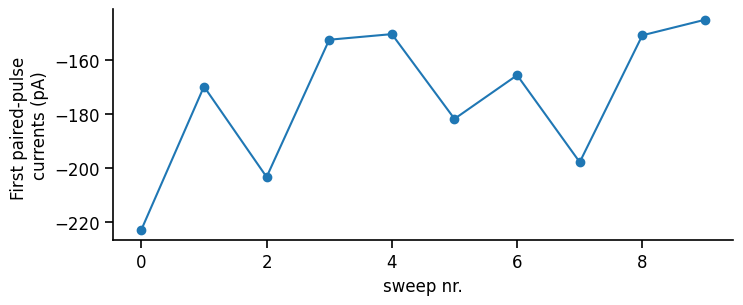

In [21]:
first_pulse_currents,_ = first_pulse_traces.get_measurements(start_time=marker_1, 
                                                            end_time=marker_2,
                                                            measurement_type='min', 
                                                            time_units=time_units)
%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
x = range(len(first_pulse_currents))
ax.plot(x, first_pulse_currents, '-o')
ax.set_ylabel('First paired-pulse \ncurrents (pA)')
ax.set_xlabel("sweep nr.")
plt.show()

### 3.3. Get the response to the second paired-pulse stim

#### Subtract single-stim response from paired-pulse trace

This allows us to recover the shape/amplitude of the second pulse, without the contribution of the first pulse

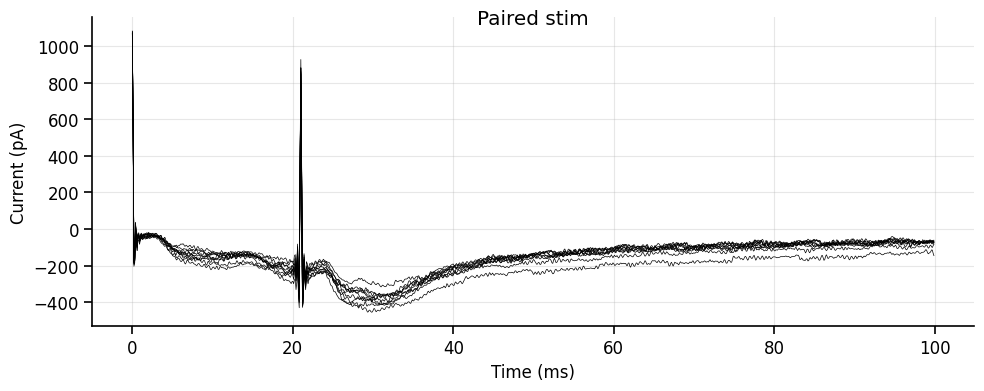

In [ ]:
paired_pulse_traces = traces.crop(timepoint=stim_times[1], window=window_size, time_units=time_units)
ax = paired_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
ax.set_title('Paired stim',y=0.95)
plt.show()

Now we will get the average "first stim" response and subtract it from all of the paired-pulse sweeps

Stim time: [21.] ms


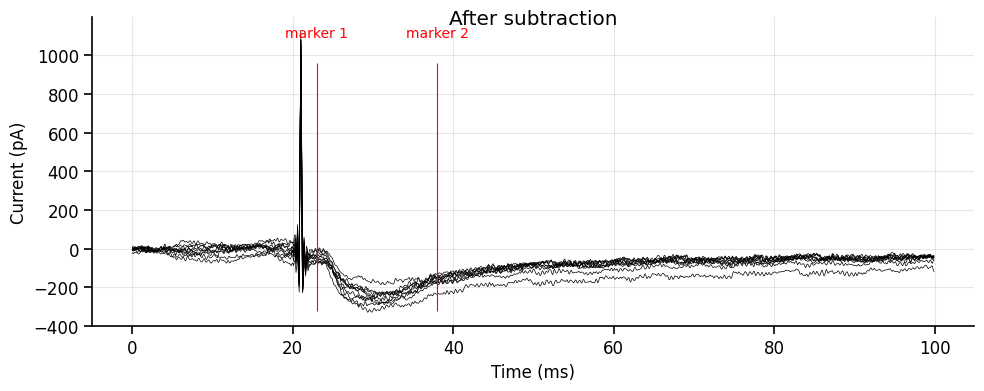

In [47]:

subtracted_traces = paired_pulse_traces.copy()
avg_single_stim_trace = np.mean(single_stim_traces.current_data, axis=0)
subtracted_traces.current_data -= avg_single_stim_trace

# Find stim artifact of the subtracted trace
stim_time = subtracted_traces.get_event_times(threshold=200, 
                                            polarity='positive', 
                                            time_units=time_units,
                                            channel='current', sweep=0)
print(f"Stim time: {stim_time} ms")

marker_1 = stim_time[0]+2
marker_2 = stim_time[0]+17

ax = subtracted_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all', marker_1=marker_1, marker_2=marker_2)
ax.set_title('After subtraction',y=0.95)
plt.show()

#### Measure second paired-pulse amplitudes

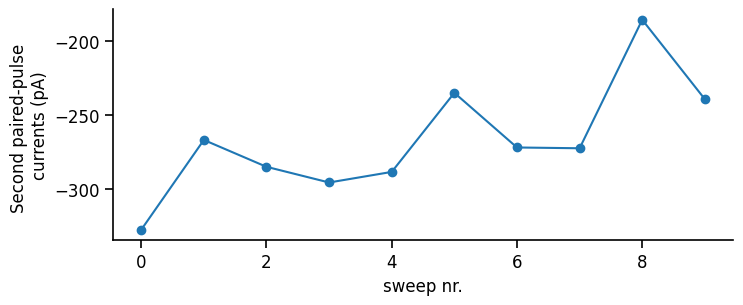

In [48]:
second_pulse_currents,_ = subtracted_traces.get_measurements(start_time=marker_1,
                                                            end_time=marker_2, 
                                                            measurement_type='min', 
                                                            time_units=time_units)
fig,ax = plt.subplots(figsize=(8,3))
x = range(len(second_pulse_currents))
ax.plot(x, second_pulse_currents, '-o')
ax.set_ylabel('Second paired-pulse \ncurrents (pA)')
ax.set_xlabel("sweep nr.")
plt.show()

### 3.4. Plot paired-pulse ratio

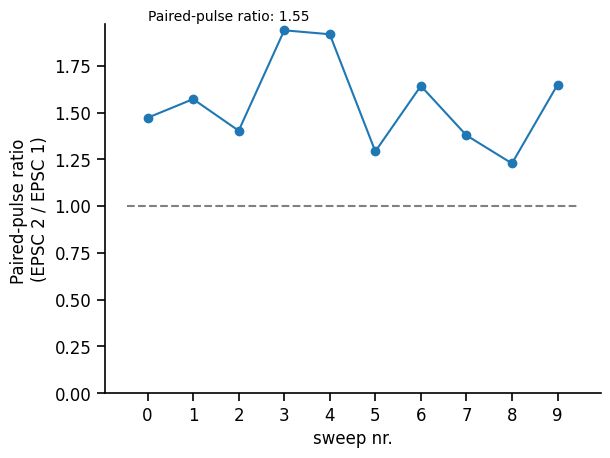

In [49]:
if len(first_pulse_currents) == len(second_pulse_currents):
    paired_pulse_ratios = second_pulse_currents / first_pulse_currents
    avg_ppr = np.mean(paired_pulse_ratios)
    fig,ax = plt.subplots()
    ax.plot(paired_pulse_ratios, '-o')
    ax.set_xticks(range(len(second_pulse_currents)))
    xlims = ax.get_xlim()
    ax.set_ylim(bottom=0)
    ylims = ax.get_ylim()
    ax.hlines(1, xlims[0],xlims[1],linestyle='--',color='gray')
    ax.text(0, ylims[1], f"Paired-pulse ratio: {avg_ppr:.2f}", fontsize=10, ha='left', va='bottom')
    ax.set_ylabel('Paired-pulse ratio \n(EPSC 2 / EPSC 1)')
    ax.set_xlabel("sweep nr.")
    plt.show()
else:
    avg_second_pulse = np.mean(second_pulse_currents)
    avg_first_pulse = np.mean(first_pulse_currents)
    paired_pulse_ratio = avg_second_pulse / avg_first_pulse
    print(f"Paired-pulse ratio: {paired_pulse_ratio}")
